# XGBoost Parameter Tuning for Otto Dataset

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，进行XGBoost参数调优探索。

竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data

# 第二步：调整树的参数：max_depth & min_child_weight
(粗调，参数的步长为2；下一步是在粗调最佳参数周围，将步长降为1，进行精细调整)

首先 import 必要的模块

In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [2]:
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"Otto_train.csv")
#train.head()

## Variable Identification

选择该数据集是因为的数据特征单一，我们可以在特征工程方面少做些工作，集中精力放在参数调优上

## Target 分布，看看各类样本分布是否均衡

In [3]:
#sns.countplot(train.target);
#pyplot.xlabel('target');
#pyplot.ylabel('Number of occurrences');

每类样本分布不是很均匀，所以交叉验证时也考虑各类样本按比例抽取

In [4]:
# drop ids and get labels
y_train = train['target']
y_train = y_train.map(lambda s: s[6:])
y_train = y_train.map(lambda s: int(s)-1)

train = train.drop(["id", "target"], axis=1)
X_train = np.array(train)

各类样本不均衡，交叉验证是采用StratifiedKFold，在每折采样时各类样本按比例采样

In [5]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

第一轮参数调整得到的n_estimators最优值（699），其余参数继续默认值

用交叉验证评价模型性能时，用scoring参数定义评价指标。评价指标是越高越好，因此用一些损失函数当评价指标时，需要再加负号，如neg_log_loss，neg_mean_squared_error 详见sklearn文档：http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss

In [6]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = range(3,10,2)
min_child_weight = range(1,6,2)
param_test2_1 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_1

{'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]}

In [7]:
xgb2_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=2,  #第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch2_1 = GridSearchCV(xgb2_1, param_grid = param_test2_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_1.fit(X_train , y_train)

gsearch2_1.grid_scores_, gsearch2_1.best_params_,     gsearch2_1.best_score_

/Applications/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -1.89738, std: 0.00740, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -1.89750, std: 0.00731, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -1.89795, std: 0.00730, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -1.84625, std: 0.01128, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -1.84747, std: 0.01117, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -1.84842, std: 0.01125, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -1.81426, std: 0.00648, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -1.81820, std: 0.00657, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -1.82191, std: 0.00701, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -1.80225, std: 0.00421, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -1.80935, std: 0.00393, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -1.81214, std: 0.00311, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 9, 'min_chil

In [8]:
gsearch2_1.cv_results_

{'mean_fit_time': array([ 2.23074861,  2.65763454,  2.69463925,  3.30102944,  3.62995882,
         3.59766273,  4.28756704,  4.49844666,  4.48730793,  5.3142704 ,
         5.55349984,  4.68907838]),
 'mean_score_time': array([ 0.16698532,  0.07552595,  0.10664678,  0.10792656,  0.0900722 ,
         0.11578994,  0.12307835,  0.12351956,  0.13793001,  0.17913656,
         0.16294136,  0.10563679]),
 'mean_test_score': array([-1.89738453, -1.89749741, -1.89794523, -1.84625175, -1.84746907,
        -1.84842319, -1.81425999, -1.81819681, -1.82191243, -1.80225298,
        -1.80935193, -1.81214152]),
 'mean_train_score': array([-1.89582817, -1.89601021, -1.89646037, -1.84306682, -1.84496196,
        -1.84615697, -1.80789678, -1.81299341, -1.81775794, -1.79172928,
        -1.80148929, -1.80581986]),
 'param_max_depth': masked_array(data = [3 3 3 5 5 5 7 7 7 9 9 9],
              mask = [False False False False False False False False False False False False],
        fill_value = ?),
 'param_m

Best: -1.802253 using {'max_depth': 9, 'min_child_weight': 1}


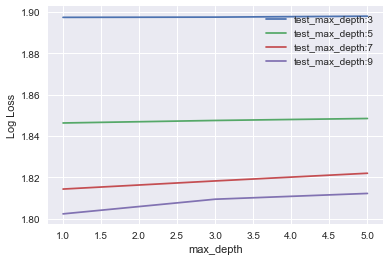

In [10]:
# summarize results
print("Best: %f using %s" % (gsearch2_1.best_score_, gsearch2_1.best_params_))
test_means = gsearch2_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_1.cv_results_[ 'std_test_score' ]
train_means = gsearch2_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_1.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch2_1.cv_results_).to_csv('my_preds_maxdepth_min_child_weights_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(max_depth), len(min_child_weight))
train_scores = np.array(train_means).reshape(len(max_depth), len(min_child_weight))

for i, value in enumerate(max_depth):
    pyplot.plot(min_child_weight, -test_scores[i], label= 'test_max_depth:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'max_depth' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig('max_depth_vs_min_child_weght_1.png' )